#**Second Section

In [ ]:
#pip install tensorflow==1.14

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from random import randint
from imgaug import augmenters
import matplotlib.pyplot as plt
from numpy import argmax, array_equal
from sklearn.model_selection import train_test_split

##Data preprocessing

###Download the dataset

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

###Black and White format

In [5]:
def grayscale(im):
    return im.reshape(im.shape[0], 3, 32, 32).mean(1).reshape(im.shape[0], -1)

###Loading into memory

In [6]:
data, labels = [], []

for i in range(1, 6):
    filename = '/content/cifar-10-batches-py/data_batch_' + str(i)
    open_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, open_data['data']))
        labels = np.hstack((labels, open_data['labels']))
    else:
        data = open_data['data']
        labels = open_data['labels']

In [7]:
data = grayscale(data)
x = np.matrix(data)
y = np.array(labels)
print('X: ', x.shape)
print('Y: ', y.shape)

X:  (50000, 1024)
Y:  (50000,)


In [8]:
horse_i = np.where(y == 7)[0]
horse_x = x[horse_i]
print(np.shape(horse_x)) 

(5000, 1024)


###Ploting figures

In [9]:
def plot_image(image, shape=[32, 32], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")

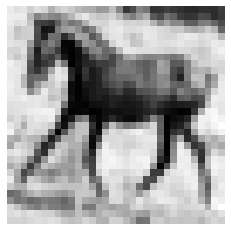

In [10]:
plot_image(horse_x[53], shape=[32, 32], cmap = "Greys_r")	

##Dataset Estimator

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
(1, 1024)


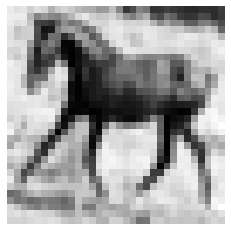

In [11]:
# Parameters
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

n_inputs = 32 * 32
BATCH_SIZE = 1
batch_size = tf.placeholder(tf.int64)

# placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
# Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

# Print the image
with tf.Session() as sess:
    # feed the placeholder with data
    sess.run(iter.initializer, feed_dict={x: horse_x[53], batch_size: BATCH_SIZE}) 
    print(sess.run(features).shape) 
    plot_image(sess.run(features), shape=[32, 32], cmap = "Greys_r")

##Building Network

###Define the parameters

In [12]:
from functools import partial

# Encoder
n_hidden_1 = 200
n_hidden_2 = 100  # codings

# Decoder
n_hidden_3 = n_hidden_1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

In [13]:
import tensorflow as tf

#Xavier initialization
xav_init =  tf.contrib.layers.xavier_initializer()
#L2 regularizer
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



###Define the layers

In [14]:
#dense layer
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

In [15]:
hidden_1 = dense_layer(features, n_hidden_1)
hidden_2 = dense_layer(hidden_1, n_hidden_2)
hidden_3 = dense_layer(hidden_2, n_hidden_3)
outputs = dense_layer(hidden_3, n_outputs, activation=None)

Instructions for updating:
Use keras.layers.dense instead.


###Define the optimization

In [16]:
loss = tf.reduce_mean(tf.square(outputs - features))
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

In [17]:
BATCH_SIZE = 100
# Number of batches :  length dataset / batch size
n_batches = horse_x.shape[0] // BATCH_SIZE
print(n_batches)

50


###Run the model

In [18]:
## Set params
n_epochs = 100

## Call Saver to save the model and re-use it later during evaluation
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # initialise iterator with train data
    sess.run(iter.initializer, feed_dict={x: horse_x,
                                          batch_size: BATCH_SIZE})
    print('Training...')
    print(sess.run(features).shape) 
    for epoch in range(n_epochs):       
        for iteration in range(n_batches):
            sess.run(train)
        if epoch % 10 == 0:
            loss_train = loss.eval()   # not shown
            print("\r{}".format(epoch), "Train MSE:", loss_train) 
        #saver.save(sess, "./my_model_all_layers.ckpt") 
    save_path = saver.save(sess, "./model.ckpt")    
    print("Model saved in path: %s" % save_path) 

Training...
(100, 1024)
0 Train MSE: 2693.0269
10 Train MSE: 1494.4409
20 Train MSE: 1451.501
30 Train MSE: 1432.4578
40 Train MSE: 1597.9347
50 Train MSE: 1361.5663
60 Train MSE: 1420.472
70 Train MSE: 1409.49
80 Train MSE: 1477.1985
90 Train MSE: 1418.7662
Model saved in path: ./model.ckpt


###Evaluate the model

In [19]:
test_data = unpickle('/content/cifar-10-batches-py/test_batch')
test_x = grayscale(test_data['data'])
test_labels = np.array(test_data['labels'])

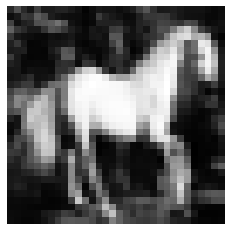

In [20]:
plot_image(test_x[13], shape=[32, 32], cmap = "Greys_r")	

In [21]:
def reconstruct_image(df, image_number = 1):
    ## Part 1: Reshape the image to the correct dimension i.e 1, 1024
    x_test = df[image_number]
    x_test_1 = x_test.reshape((1, 32*32))
    
    ## Part 2: Feed the model with the unseen image, encode/decode the image
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer()) 
        sess.run(iter.initializer, feed_dict={x: x_test_1,
                                      batch_size: 1})
    ## Part 3:  Print the real and reconstructed image
      # Restore variables from disk.
        saver.restore(sess, "./model.ckpt")  
        print("Model restored.")
      # Reconstruct image
        outputs_val = outputs.eval()
        print(outputs_val.shape)
        fig = plt.figure()
      # Plot real
        ax1 = fig.add_subplot(121)
        plot_image(x_test_1, shape=[32, 32], cmap = "Greys_r")
      # Plot estimated
        ax2 = fig.add_subplot(122)
        plot_image(outputs_val, shape=[32, 32], cmap = "Greys_r")
        plt.tight_layout()
        fig = plt.gcf()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
(1, 1024)


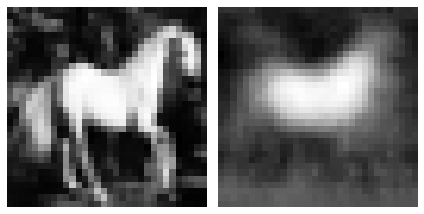

In [22]:
reconstruct_image(df =test_x, image_number = 13)